# Softmax

> 损失图像的空间信息

- 回归估计一个连续值
- 分类预测一个离散类别

|回归|分类|
-|-
|单连续数值输出|多个离散值输出|
|自然区间 $R$ | 输出i是第i类的置信度|
|和真实值的区别作为损失||

1. 类别进行独热编码
2. 可以使用均方损失
3. 关心正确类的置信度远大于其他类的置信度

**输出匹配概率**

$$y_i = \frac{e^{o_i}}{\sum_k e^{o_k}}$$

> 非负且行和为1

**损失函数**

交叉熵损失：

$$loss(y, \hat{y})=-\sum_iy_i\log{\hat{y_i}} = -\log{\hat{y_y}}$$

> 由于是独热编码，真实值中仅有一个值为1

梯度：

$$d_{o_i}loss(y, \hat{y})=softmax(o)_i-y_i$$

## 损失函数

**L2 Loss**

$$loss(y,y')=\frac{1}{2}(y-y')^2$$

> 梯度呈二次函数，离原点越远，梯度越大

**L1 Loss**

$$loss(y,y')=|y-y'|$$

> 优点是，梯度保持恒定值，缺点是零点不可导，不平滑

**Huber's Robust Loss**

$$loss(y,y')=\begin{cases}|y-y'|-\frac{1}{2}&if|y-y'|>1\\\frac{1}{2}(y-y')^2&otherwise\end{cases}$$

> 两者的结合，一阶可导

In [1]:
%pip install matplotlib.inline

Looking in indexes: https://pypi.douban.com/simple/
Note: you may need to restart the kernel to use updated packages.


### 1 图像数据集

In [2]:
""" preliminary """
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
import torch
import torchvision # 视觉模型的库
from torch.utils import data
from torchvision import transforms
import os
%matplotlib inline
backend_inline.set_matplotlib_formats('svg')

**下载 Fashion-MNIST**

In [3]:
# 使用 ToTensor 将图像数据从 PIL 类型变换为 32 为浮点数
trans = transforms.ToTensor() # 自动归一化成 0-1 
mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=trans, download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
""" 获得标签索引对应文本"""
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', \
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [5]:
""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

In [6]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
X.shape, y.shape

(torch.Size([18, 1, 28, 28]), torch.Size([18]))

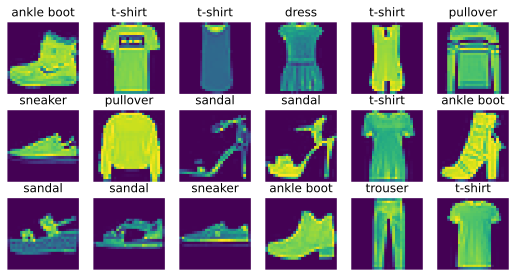

In [7]:
show_img(X.reshape((18, 28, 28)), 3, 6, title=get_fashion_mnist_labels(y))

In [8]:
batch_size = 256
cpu_cores = os.cpu_count()
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=cpu_cores) # 构建数据集

In [9]:
import time
""" 测试读取时间 """
start = time.perf_counter()
for X, y in train_iter:
    continue
end = time.perf_counter()
print(f"time : {end-start:8f} sec")
# 读取时间要快于训练时间

time : 11.588147 sec


# Softmax 从零开始

In [10]:
""" 数据集 """
cpu_cores = os.cpu_count()
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=cpu_cores)
test_iter = data.DataLoader(mnist_train, batch_size, shuffle=False, num_workers=cpu_cores)
for X, y in test_iter:
    print(X.shape, y.shape)
    break
cpu_cores

torch.Size([256, 1, 28, 28]) torch.Size([256])


12

In [11]:
""" 参数初始化 """
num_inputs = 28 * 28 # softmax 输入是向量，所以要展平
num_outputs = 10
W = torch.normal(mean=0, std=0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

$$Softmax(x) = \frac{e^{o_i}}{\sum_k e^{o_k}}$$

In [12]:
""" Softmax 实现 """
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 使用广播机制 

In [13]:
""" 网络定义 """
def net(X):
    # 依旧使用的是线性回归 but 十输出
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)
    # X 应该是 256(batch_size) * 784(input_num)
    # X(256x784) x W(784x10) = Out(256x10)
    # 广播机制加上偏移

In [14]:
""" 索引 """
y = torch.tensor([0, 2])
y_hat = torch.arange(6, dtype=torch.float32).reshape([2, 3])
print(y_hat, len(y_hat))
print(y_hat[[0, 1], y])
# 相当于用 tensor 切片
# 前面是行，后面是列

tensor([[0., 1., 2.],
        [3., 4., 5.]]) 2
tensor([0., 5.])


$$loss(y, \hat{y})=-\sum_iy_i\log{\hat{y_i}} = -\log{\hat{y_y}}$$

In [15]:
""" 交叉熵损失函数 """
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y]) # 独热编码，y的值对应 y_hat 应该最大
    # 行取 len(y_hat) = 256, 列取 y 真值对应的列

In [16]:
""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

In [17]:
accuracy(y_hat, y) / len(y)

0.5

In [18]:
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [19]:
""" 评估 net 的准确性 """
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() # 如果是 torch 神经网络，则设置为评估模式，不进行反向传播
    accum = Accumulator(2)
    for X, y in data_iter:
        accum.add(accuracy(net(X), y), y.numel())
    return accum[0] / accum[1]


In [20]:
evaluate_accuracy(net, test_iter) # 随机正确率约为 10%

0.09775

In [21]:
""" 梯度下降更新器 """
def sgd_updater(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 累加梯度
            param.grad.zero_() # 梯度清理

In [22]:
""" 一轮训练 """
def train_epoch_ch3(net, train_iter, loss, params, updater, lr):
    if isinstance(net, torch.nn.Module):
        net.train() # 训练模式，进行反向传播
    metric = Accumulator(3)
    for X, y in train_iter:
        l = loss(net(X), y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
        else:
            l.sum().backward()
            updater(params, lr, len(X)) # 更新器需要 batch_size
        metric.add(float(l.sum()), accuracy(net(X), y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [23]:
""" 训练函数 """
def train_ch3(net, train_iter, test_iter, loss, num_epochs, params, updater, lr):
    accumulator = [Accumulator(3) for _ in range(num_epochs)]
    for epoch in range(num_epochs):
        start = time.perf_counter()
        train_metrics = train_epoch_ch3(net, train_iter, loss, params, updater, lr) # 训练误差
        test_accuracy = evaluate_accuracy(net, test_iter) # 测试误差
        accumulator[epoch].add(train_metrics[0], train_metrics[1], test_accuracy)
        end = time.perf_counter()
        print(f"Finish {epoch + 1} train, cose {end-start:.3f} sec")
    return accumulator

In [24]:
""" 训练 """
lr = 0.05
num_epochs = 20
all_start = time.perf_counter()
accumulator = train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, [W, b], sgd_updater, lr)
all_end = time.perf_counter()
print(f"\n Totally use {all_end-all_start:.3f} sec")

Finish 1 train, cose 21.682 sec
Finish 2 train, cose 22.690 sec
Finish 3 train, cose 22.382 sec
Finish 4 train, cose 21.132 sec
Finish 5 train, cose 21.580 sec
Finish 6 train, cose 23.186 sec
Finish 7 train, cose 22.063 sec
Finish 8 train, cose 22.222 sec
Finish 9 train, cose 22.025 sec
Finish 10 train, cose 21.393 sec
Finish 11 train, cose 22.113 sec
Finish 12 train, cose 21.940 sec
Finish 13 train, cose 21.857 sec
Finish 14 train, cose 21.984 sec
Finish 15 train, cose 22.356 sec
Finish 16 train, cose 21.423 sec
Finish 17 train, cose 22.701 sec
Finish 18 train, cose 18.810 sec
Finish 19 train, cose 10.641 sec
Finish 20 train, cose 10.980 sec

 Totally use 415.173 sec


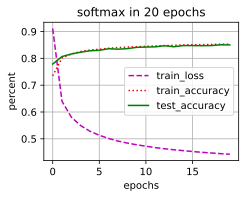

In [25]:
""" 绘图 """
backend_inline.set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (3.5, 2.5)

train_loss, train_accuracy, test_accuracy = [], [], []
for i in range(num_epochs):
    train_loss.append(accumulator[i][0])
    train_accuracy.append(accumulator[i][1])
    test_accuracy.append(accumulator[i][2])
    
plt.plot(list(range(num_epochs)), train_loss, 'm--')
plt.plot(list(range(num_epochs)), train_accuracy, 'r:')
plt.plot(list(range(num_epochs)), test_accuracy, 'g-')
plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
plt.xlabel('epochs')
plt.ylabel('percent')
plt.title(f'softmax in {num_epochs} epochs')
plt.grid(True)

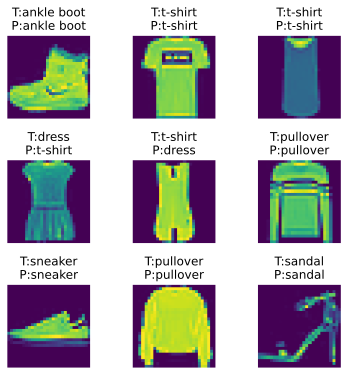

In [26]:
def predtic_ch3(net, test_iter, rows, cols):
    n = rows * cols
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    predicts = get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [f"T:{true}\nP:{predict}" for true, predict in zip(trues, predicts)]
    show_img(X[0:n].reshape([n, 28, 28]), rows, cols, title=title[0:n], scale=2)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
predtic_ch3(net, test_iter, 3, 3)

**softmax 的 label**

由于独热编码，只存在 0, 1 但是 0, 1 很难由概率逼近，一般使用 0.1, 0.9

> 但是 0, 1编码可以使得错误类被消去, 损失函数只需要正确的类

**MSE 和 似然函数**

最小化损失，等价于最大化权重